# 🏎️ Projet Classification F1 - Prédiction des résultats

# Objectif du notebook – Classification en Formule 1

Ce notebook a pour but d’évaluer la capacité de plusieurs modèles de classification supervisée à prédire différents événements liés aux performances des pilotes de Formule 1, en s’appuyant sur un ensemble de données historiques couvrant la période de 1950 à 2024.

L’objectif est de comparer plusieurs algorithmes afin d’identifier les plus performants selon le type de prédiction à effectuer.


## Questions posées

- Le pilote va-t-il terminer la course ?
- Le pilote va-t-il monter sur le podium ?
- Le pilote va-t-il battre son coéquipier ?
- Le pilote partira-t-il dans le top 10 sur la grille de départ ?
- Le pilote va-t-il gagner des positions entre le départ et l’arrivée ?

## Méthodes comparées

Cinq classifieurs supervisés sont évalués pour mesurer leur efficacité sur ces différentes cibles.

### Méthodes ensemblistes :
- `RandomForestClassifier`
- `AdaBoostClassifier`

### Méthodes classiques vues en cours :
- `SVC` (Support Vector Classifier)
- `KNeighborsClassifier`

### Méthode avancée non abordée en cours :
- `MLPClassifier` (réseau de neurones)


## Table des matières

1. [Introduction](#objectif-du-notebook--classification-en-formule-1)  
2. [Chargement des bibliothèques](#chargement-des-bibliothèques-nécessaires-à-la-classification-f1)  
3. [Chargement des données](#chargement-des-données)  
4. [Définition des variables explicatives](#définition-des-features)  
5. [Prétraitement des données](#prétraitement-des-données)  
6. [Définition des modèles](#modèles-comparés)  
7. [Boucle d'entraînement et d'évaluation](#entraînement-et-évaluation-multi-target)  
8. [Résultats globaux](#résultats-des-classifieurs)  
9. [Visualisation des scores](#visualisation-des-scores-par-target)  
10. [Matrices de confusion](#matrices-de-confusion-par-target)  
11. [Meilleurs modèles par cible](#meilleurs-modèles-par-cible)  
12. [Analyse croisée des performances](#analyse-croisée-des-résultats)  
13. [Conclusion et ouverture](#conclusion--bilan-de-la-classification)

## Chargement des bibliothèques nécessaires à la classification F1

In [34]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

## Chargement des données

In [35]:
print("\n Chargement des données...")
df = pd.read_csv("../data/data_filter.csv")


 Chargement des données...


C:\Users\rapha\AppData\Local\Temp\ipykernel_18420\2731475583.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/data_filter.csv")


## Définition des features

In [36]:
features = [
    'grid', 'laps', 'driver_age',
    'rank', 'rank_missing', 'finished_race',
    'year', 'constructor_name', 'races_name',
    'gp_nationality', 'is_home_race'
] # A ajuster ...

X = df[features]

On définit ici :
- `features` : les variables explicatives sélectionnées à partir du dataset. 
Ces variables ont été choisies pour éviter toute fuite d'information (exclusion de `points`, `positionOrder`, etc.).

## Définition des colonnes pour le prétraitement

In [37]:
numeric_features = ['grid', 'laps', 'driver_age', 'rank', 'rank_missing', 'year', 'is_home_race']
categorical_features = ['constructor_name', 'races_name', 'gp_nationality']

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

Cette section prépare le pipeline de prétraitement pour les données :  
- Les variables numériques (`numeric_features`) sont normalisées via `StandardScaler`, ce qui permet de mettre toutes les valeurs à la même échelle, indispensable pour certains modèles (ex : SVM, MLP).  
- Les variables catégorielles (`categorical_features`) sont transformées en vecteurs binaires via `OneHotEncoder`, ce qui permet d’intégrer des informations qualitatives comme le nom du circuit ou le constructeur sans introduire d’ordre arbitraire.   L’ensemble est combiné dans un `ColumnTransformer`, qui applique les traitements respectifs sur les colonnes désignées.

## Définition des modèles à tester

In [38]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42),
    "SVC": SVC(kernel="rbf", C=1.0, random_state=42),
    "KNeighbors": KNeighborsClassifier(n_neighbors=5),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

Ce dictionnaire contient les cinq modèles testés dans le projet.  
Les paramètres sont choisis pour assurer des performances correctes et des résultats reproductibles :

- `RandomForestClassifier` : 200 arbres, bon compromis entre stabilité et performance.
- `AdaBoostClassifier` : 200 itérations pour améliorer progressivement la précision.
- `SVC` : noyau RBF avec C=1.0 (réglage standard), adapté aux problèmes non linéaires.
- `KNeighborsClassifier` : prend en compte les 5 plus proches voisins.
- `MLPClassifier` : réseau de neurones simple avec une couche de 100 neurones, max 300 itérations.

Le paramètre `random_state=42` est utilisé pour garantir la reproductibilité des résultats.


## Cibles à prédire

In [39]:
all_targets = [
    "target_finish_race", # Le pilote a-t-il terminé la course ?
    "target_podium", # Le pilote a-t-il terminé sur le podium ?
    "target_top10", # Le pilote a-t-il terminé dans le top 10 ?
    "target_gain_position", # Le pilote a-t-il gagné des positions ?
    "target_beat_teammate" # Le pilote a-t-il battu son coéquipier ?
]

all_results = []

On définit ici :
- `all_targets` : les différentes questions que l’on souhaite prédire.

## Entraînement + évaluation pour chaque target

In [40]:
for target in all_targets:
    print(f"\n Évaluation pour la cible : {target}")
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    for name, model in models.items():
        if name == 'KNeighbors':
            X_small, _, y_small, _ = train_test_split(X, y, test_size=0.5, random_state=42)
            X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_small, y_small, test_size=0.3, random_state=42)

            pipeline = Pipeline([
                ('preprocessing', preprocessor),
                ('classifier', model)
            ])
            pipeline.fit(X_train_k, y_train_k)
            y_pred = pipeline.predict(X_test_k)

            all_results.append({
                'Target': target,
                'Modèle': name,
                'Accuracy': accuracy_score(y_test_k, y_pred),
                'F1 Score': f1_score(y_test_k, y_pred)
            })
        else:
            pipeline = Pipeline([
                ('preprocessing', preprocessor),
                ('classifier', model)
            ])
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)

            all_results.append({
                'Target': target,
                'Modèle': name,
                'Accuracy': accuracy_score(y_test, y_pred),
                'F1 Score': f1_score(y_test, y_pred)
            })


 Évaluation pour la cible : target_finish_race


c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



 Évaluation pour la cible : target_podium


c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



 Évaluation pour la cible : target_top10

 Évaluation pour la cible : target_gain_position


c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



 Évaluation pour la cible : target_beat_teammate


c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Cette boucle entraîne chaque modèle sur toutes les cibles (`target_*`) définies.  
Pour chaque modèle, on calcule l’accuracy et le F1 score sur un jeu de test.  
Le classifieur KNeighbors utilise un sous-échantillonnage car il est plus coûteux en mémoire.  
Tous les résultats sont enregistrés dans une liste pour être analysés ensuite.

## Résultats des modèles

In [41]:
print("\n Tableau récapitulatif des modèles")
df_results = pd.DataFrame(all_results).sort_values(by=["Target", "F1 Score"], ascending=[True, False])
display(df_results)


 Tableau récapitulatif des modèles


,Target,Modèle,Accuracy,F1 Score
22,target_beat_teammate,SVC,0.679372,0.690402
21,target_beat_teammate,AdaBoost,0.659442,0.678353
20,target_beat_teammate,RandomForest,0.642128,0.635452
24,target_beat_teammate,MLPClassifier,0.617464,0.606433
23,target_beat_teammate,KNeighbors,0.592676,0.588057
0,target_finish_race,RandomForest,0.939337,0.889293
4,target_finish_race,MLPClassifier,0.919283,0.858144
2,target_finish_race,SVC,0.918161,0.850512
1,target_finish_race,AdaBoost,0.915919,0.844792
3,target_finish_race,KNeighbors,0.900847,0.824360


## 🔍 Analyse croisée des résultats

Les performances des modèles sont cohérentes avec les tendances identifiées dans l’EDA :

- `target_top10` est prédite quasi parfaitement grâce à sa forte corrélation avec la grille de départ (`grid`).

- `target_finish_race` et `target_podium` sont bien modélisées (F1 > 0.85) grâce à des variables bien représentées comme `laps`, `rank` et `finished_race`.

- `target_gain_position` est plus difficile à capter mais reste modérément prédictible.

- `target_beat_teammate` est la plus complexe à modéliser (F1 ~0.69), car elle dépend d’une dynamique interne non entièrement observable.

`RandomForest` et `SVC` ressortent comme les modèles les plus fiables sur l’ensemble des cibles.


## Matrices de confusion par cible


 Matrices de confusion — target_finish_race


c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


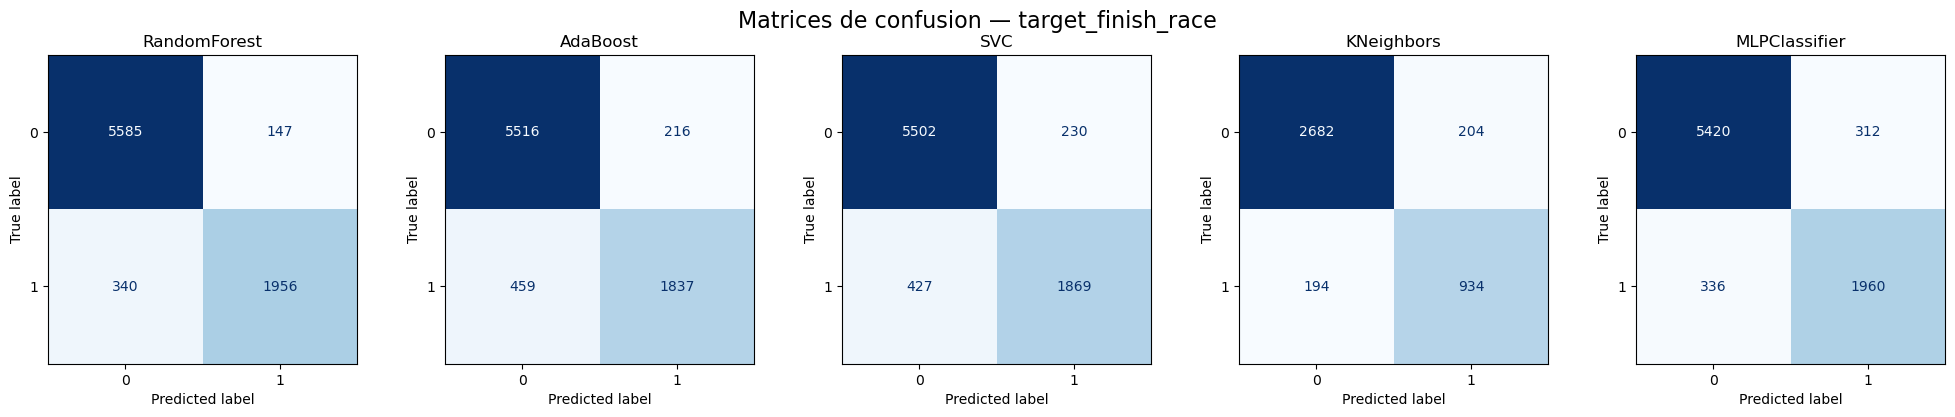


 Matrices de confusion — target_podium


c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


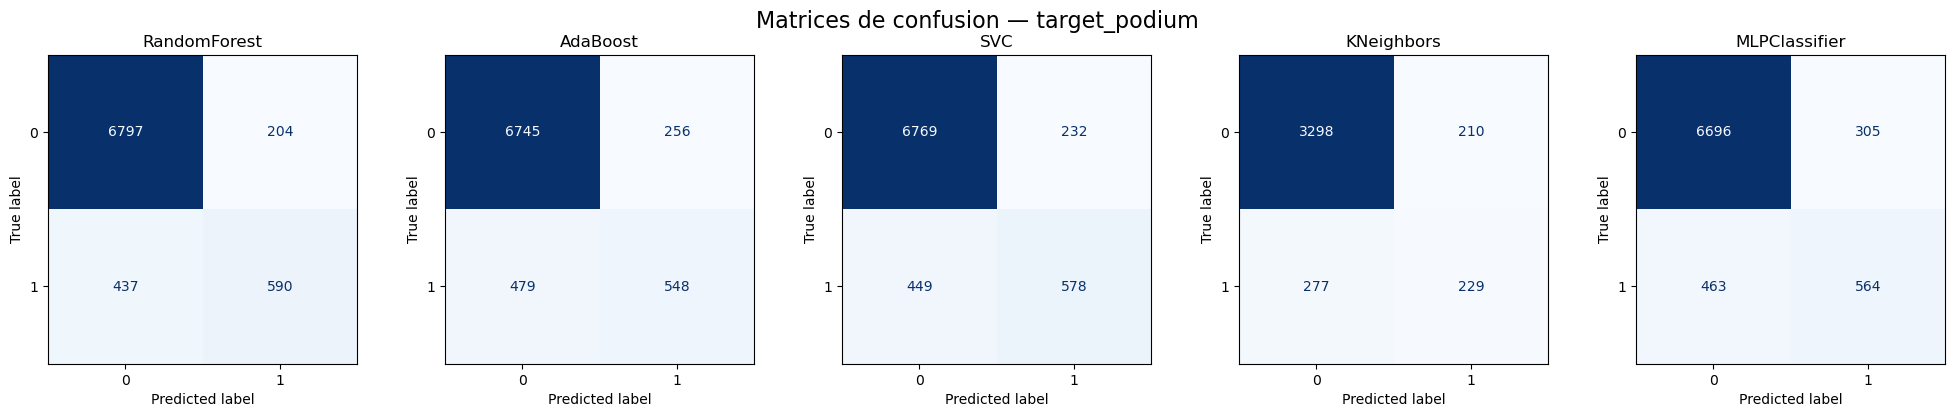


 Matrices de confusion — target_top10


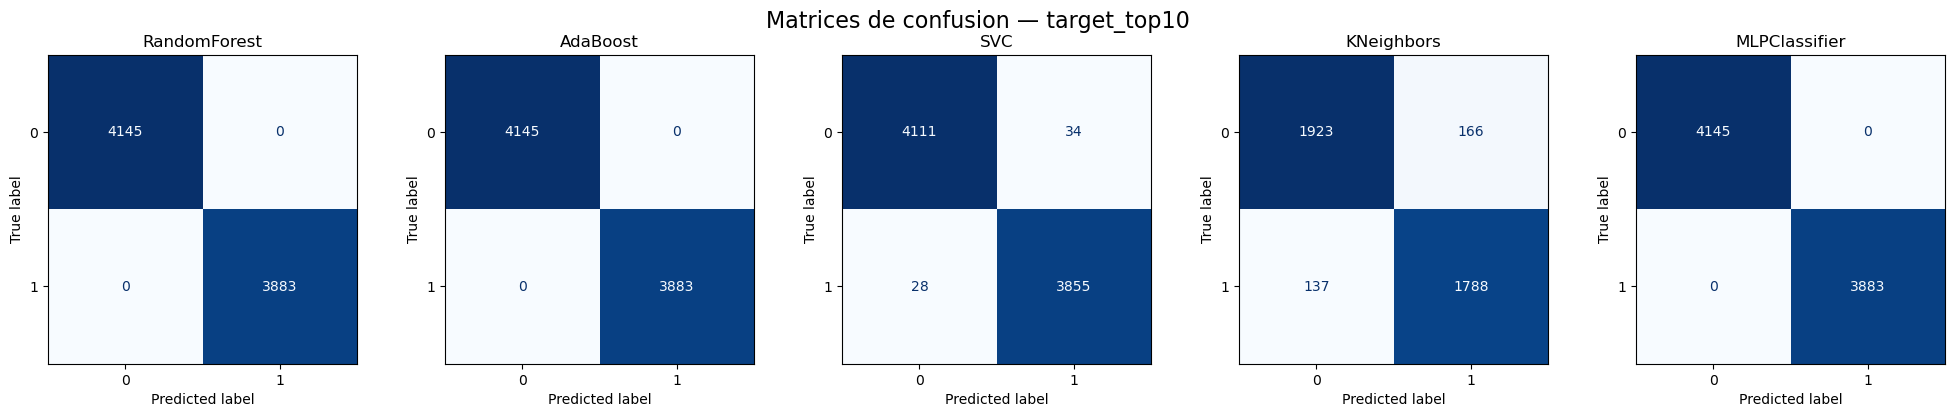


 Matrices de confusion — target_gain_position


c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


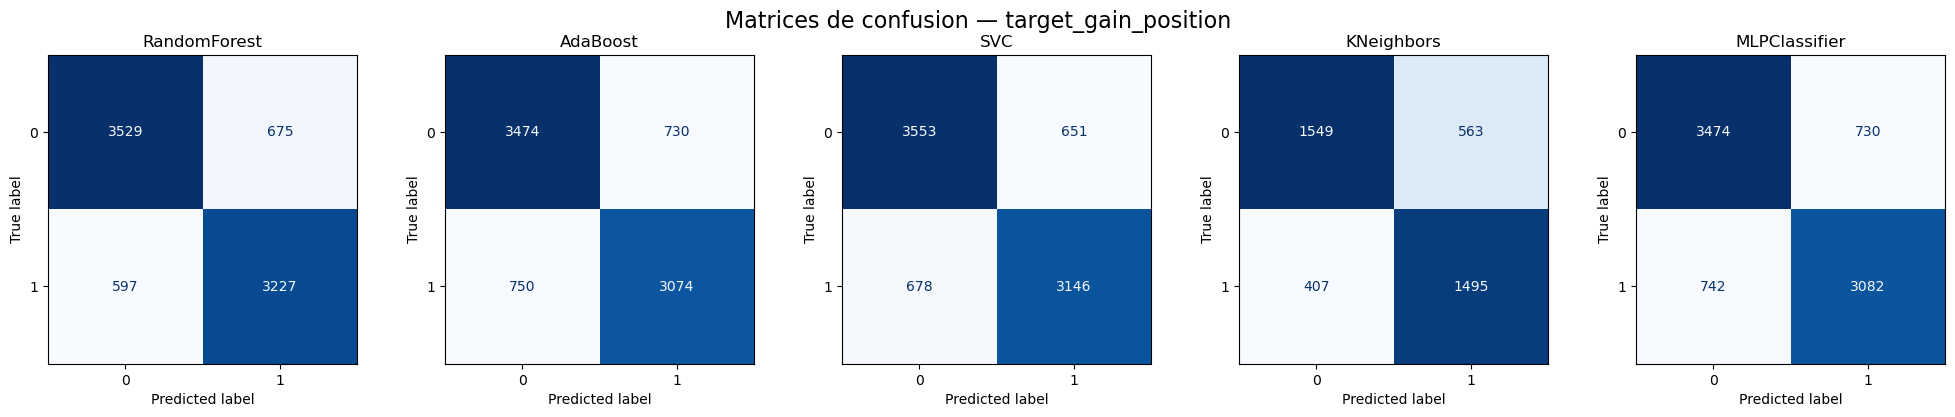


 Matrices de confusion — target_beat_teammate


c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


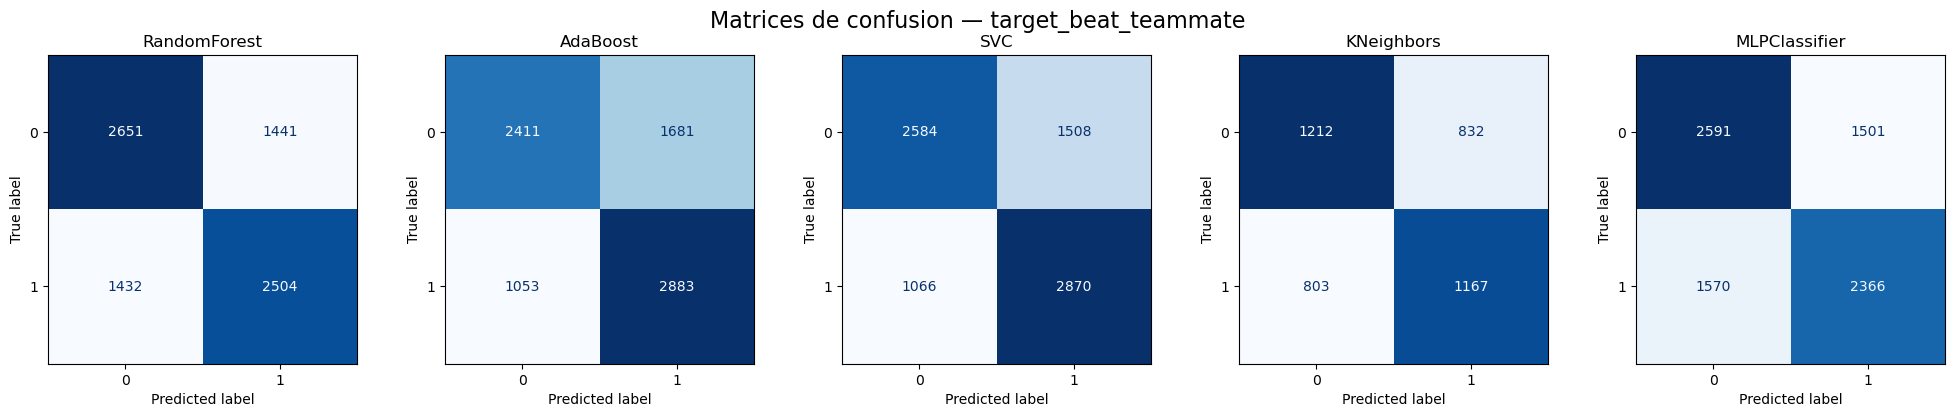

In [42]:
for target in all_targets:
    print(f"\n Matrices de confusion — {target}")
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    fig, axes = plt.subplots(1, len(models), figsize=(20, 4))
    fig.suptitle(f"Matrices de confusion — {target}", fontsize=16)

    for idx, (name, model) in enumerate(models.items()):
        if name == 'KNeighbors':
            X_small, _, y_small, _ = train_test_split(X, y, test_size=0.5, random_state=42)
            X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_small, y_small, test_size=0.3, random_state=42)
            X_fit, y_fit, X_eval, y_eval = X_train_k, y_train_k, X_test_k, y_test_k
        else:
            X_fit, y_fit, X_eval, y_eval = X_train, y_train, X_test, y_test

        pipeline = Pipeline([
            ('preprocessing', preprocessor),
            ('classifier', model)
        ])
        pipeline.fit(X_fit, y_fit)
        y_pred = pipeline.predict(X_eval)

        # Matrice de confusion
        cm = confusion_matrix(y_eval, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axes[idx], cmap="Blues", colorbar=False)
        axes[idx].set_title(name)

    plt.tight_layout()
    plt.show()

## Visualisation des scores par modèle

C:\Users\rapha\AppData\Local\Temp\ipykernel_18420\2418589646.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_target, x='Modèle', y='F1 Score', palette='Blues_d')


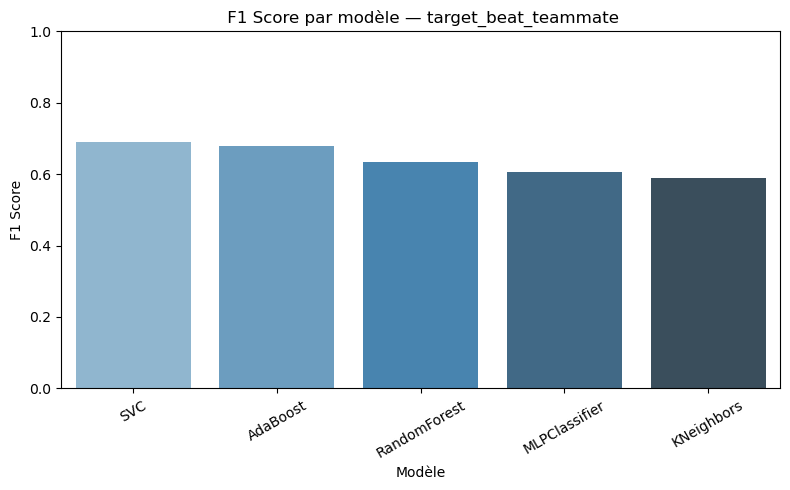

C:\Users\rapha\AppData\Local\Temp\ipykernel_18420\2418589646.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_target, x='Modèle', y='F1 Score', palette='Blues_d')


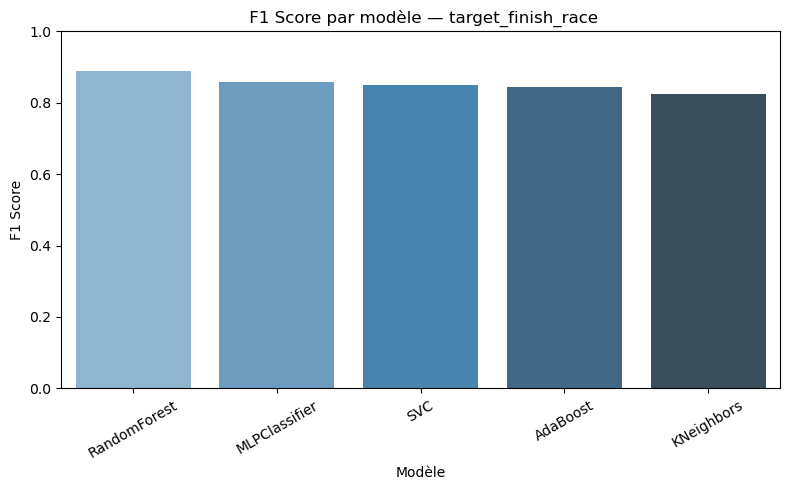

C:\Users\rapha\AppData\Local\Temp\ipykernel_18420\2418589646.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_target, x='Modèle', y='F1 Score', palette='Blues_d')


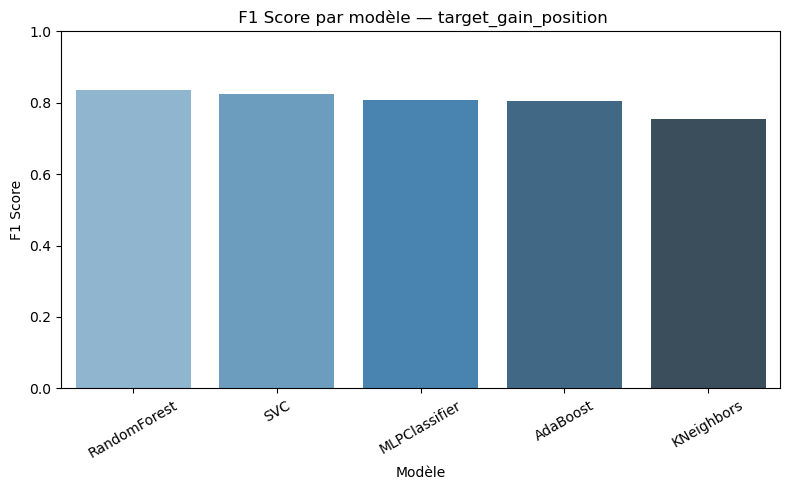

C:\Users\rapha\AppData\Local\Temp\ipykernel_18420\2418589646.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_target, x='Modèle', y='F1 Score', palette='Blues_d')


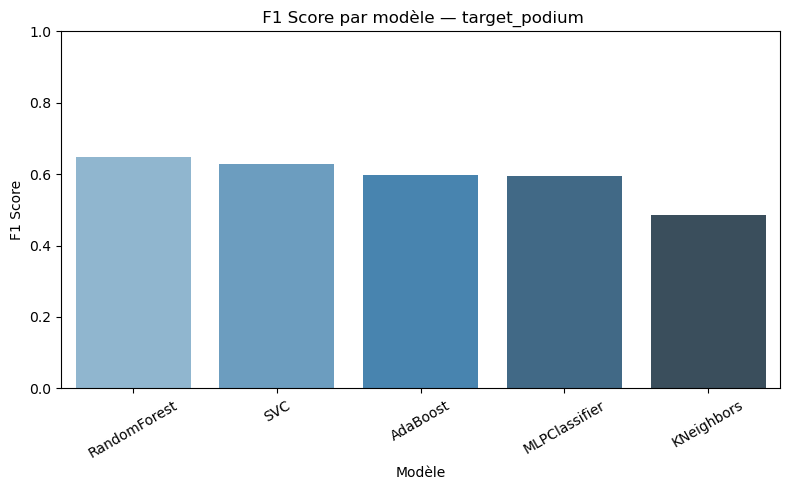

C:\Users\rapha\AppData\Local\Temp\ipykernel_18420\2418589646.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_target, x='Modèle', y='F1 Score', palette='Blues_d')


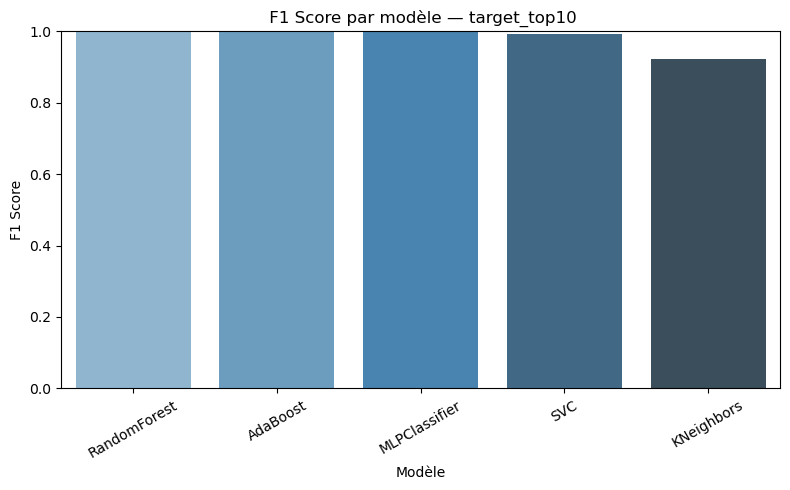

In [43]:
for target_name in df_results['Target'].unique():
    df_target = df_results[df_results['Target'] == target_name]
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_target, x='Modèle', y='F1 Score', palette='Blues_d')
    plt.title(f" F1 Score par modèle — {target_name}")
    plt.ylim(0, 1)
    plt.ylabel("F1 Score")
    plt.xlabel("Modèle")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

## Meilleurs modèles par cible

In [44]:
best_models = df_results.sort_values(by=["Target", "F1 Score"], ascending=[True, False])
best_models = best_models.groupby("Target").first().reset_index()
print("\n🏆 Meilleurs modèles par cible :")
display(best_models)


🏆 Meilleurs modèles par cible :


,Target,Modèle,Accuracy,F1 Score
0,target_beat_teammate,SVC,0.679372,0.690402
1,target_finish_race,RandomForest,0.939337,0.889293
2,target_gain_position,RandomForest,0.841555,0.835361
3,target_podium,RandomForest,0.920154,0.647996
4,target_top10,RandomForest,1.000000,1.000000


## Conclusion – Bilan de la classification

L’approche multi-target a permis d’évaluer la capacité de plusieurs modèles de machine learning à prédire différents aspects d'une course de Formule 1.

Les résultats confirment que les cibles fortement structurées (comme `target_top10`) sont très bien modélisées,  
tandis que d'autres, plus contextuelles (`target_beat_teammate`), restent plus difficiles à prédire.

Ce travail montre l'intérêt d’une évaluation comparative sur des objectifs variés, ainsi que l’importance de la sélection des features et des métriques adaptées.  
Les modèles les plus adaptés à chaque cible pourront être réutilisés dans la suite du projet, notamment pour les prédictions sur les courses de la saison 2025.

Dans la suite du projet, nous nous intéresserons à des cibles continues :  
**combien de points un pilote va-t-il marquer ?**, ou **combien de places va-t-il gagner ?**  

Nous passerons donc de la classification à la **régression**, avec une méthodologie similaire :  
- prétraitement, pipelines, sélection de modèles et analyse des performances (RMSE, R²...).